### Baseline Machine Learning Models for Classification

* Logistic Regression
* Decision Tree
* Random Forest

In this notebook we will be exploring three different Machine Learning models to classify whether a horse will win or lose a race.
Winning is defined as placing in the top three positions.

Through these models we will also perform feature performance analysis to extract the most critical features in the classification process.

In [1]:
# Import the packages we require for our analysis. 
!pip install wordninja
!pip install num2words

import pandas as pd
import numpy as np

#for pre-processing
import re, string
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
import wordninja
import num2words
from sklearn.preprocessing import OneHotEncoder

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# For plotting
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Move directory to root (590-Group-Project/)
import os
os.chdir("..")
print(os.getcwd())

/Users/eliserust/Desktop/Papers/Georgetown/Fall 2022/ANLY590/590-Group-Project


### Question #1: Predicting a horse's finish position (i.e. winner or not)

#### 1) Load the data

The data is not hosted on the GitHub repo due to its size (Git has a 100MB file size limit). Data can be found in our Google Folder at:
- https://drive.google.com/drive/folders/0ALCmvIZc4E4KUk9PVA

In [3]:
df = pd.read_csv("data/joined_data_without_position.csv")
df.head()

,Unnamed: 0,track_id,race_date,race_number,program_number,weight_carried,jockey,odds,position_at_finish,distance_id,...,Comments,seconds_in_race,humidity,precipcover,precip,temp,maxt,cloudcover,weathertype,snow
0,0,AQU,2019-01-01,1,1,123,Dylan Davis,130,2,650,...,"ins,drve5/16,outlate",79.0,73.59,20.83,0.3,50.5,59.1,67.6,"Mist, Rain, Fog, Heavy Rain, Light Rain",0.0
1,1,AQU,2019-01-01,1,2,120,Junior Alvarado,295,3,650,...,"torail1/2,6p1/8,mild",79.0,73.59,20.83,0.3,50.5,59.1,67.6,"Mist, Rain, Fog, Heavy Rain, Light Rain",0.0
2,2,AQU,2019-01-01,1,3,118,Jose Lezcano,180,4,650,...,"prompted2w,folded",79.0,73.59,20.83,0.3,50.5,59.1,67.6,"Mist, Rain, Fog, Heavy Rain, Light Rain",0.0
3,3,AQU,2019-01-01,1,4,123,Jomar Garcia,1280,5,650,...,"3wturn,alter5p1/8",79.0,73.59,20.83,0.3,50.5,59.1,67.6,"Mist, Rain, Fog, Heavy Rain, Light Rain",0.0
4,4,AQU,2019-01-01,1,5,118,Manuel Franco,1150,1,650,...,"3-4w,drve5/16,4w,up",79.0,73.59,20.83,0.3,50.5,59.1,67.6,"Mist, Rain, Fog, Heavy Rain, Light Rain",0.0


In [4]:
### Examine datatypes
df.dtypes

Unnamed: 0               int64
track_id                object
race_date               object
race_number              int64
program_number          object
weight_carried           int64
jockey                  object
odds                     int64
position_at_finish       int64
distance_id              int64
course_type             object
track_condition         object
run_up_distance          int64
race_type               object
purse                    int64
post_time                int64
last_race_track         object
day_since_last_race     object
Comments                object
seconds_in_race        float64
humidity               float64
precipcover            float64
precip                 float64
temp                   float64
maxt                   float64
cloudcover             float64
weathertype             object
snow                   float64
dtype: object

In [5]:
## Add "winner" column --> 1 if finish position == 1,2,3; 0 else
top=[1,2,3]
df["winner"] = np.where(df["position_at_finish"].isin(top), 1, 0)
print(df["winner"])

0        1
1        1
2        0
3        0
4        1
        ..
15076    1
15077    0
15078    0
15079    0
15080    0
Name: winner, Length: 15081, dtype: int64


In [6]:
## Remove "days" from day_since_last_race variable
df["day_since_last_race"] = df["day_since_last_race"].str[:2]
df["day_since_last_race"]

0        37
1        25
2        37
3        17
4        37
         ..
15076    45
15077    25
15078    18
15079    50
15080    50
Name: day_since_last_race, Length: 15081, dtype: object

In [7]:
# Get number of unique values per feature to see which are categorical vs. continuous
n = df.nunique(axis=0)
print("Number of unique values in each column: \n", n)

Number of unique values in each column: 
 Unnamed: 0             15081
track_id                   3
race_date                217
race_number               13
program_number            20
weight_carried            35
jockey                   178
odds                     656
position_at_finish        14
distance_id               20
course_type                5
track_condition            7
run_up_distance          127
race_type                 12
purse                     70
post_time                360
last_race_track          182
day_since_last_race       97
Comments                9957
seconds_in_race          447
humidity                 215
precipcover               21
precip                    53
temp                     172
maxt                     184
cloudcover               186
weathertype               50
snow                       6
winner                     2
dtype: int64


In [8]:
## Check number of missing values per column --> many models don't accept NaN
df.isna().sum()

Unnamed: 0                0
track_id                  0
race_date                 0
race_number               0
program_number            0
weight_carried            0
jockey                    0
odds                      0
position_at_finish        0
distance_id               0
course_type               0
track_condition           0
run_up_distance           0
race_type                 0
purse                     0
post_time                 0
last_race_track        1993
day_since_last_race    1993
Comments                568
seconds_in_race           0
humidity                  0
precipcover               0
precip                    0
temp                      0
maxt                      0
cloudcover                0
weathertype            5685
snow                      0
winner                    0
dtype: int64

#### 2) Pre-process data for Models

* Text data was already pre-processed (tokenized, stemmed, etc.) in the data cleaning phase but needs to be TFIDF Vectorized
* The rest of the data still needs to be encoded for classification
* Categorical Variables of interest will be:
    - track_id
    - race_date
    - jockey
    - course_type
    - track_condition
    - race_type
    - last_race_track
    - winner
* Numeric Variables of interest will be:
    - weight_carried
    - odds
    - run_up_distance
    - purse
    - *days_since_last_race*
    - seconds_in_race
    - humidity
    - precipcover
    - precip
    - temp
    - maxt
    - cloudcover
    - weathertype
    - snow
* Text Variables
    - Comments

In [9]:
#### Remove redundance variables
df = df.drop(columns=['position_at_finish', 'post_time', 'distance_id', 'seconds_in_race'])

# Convert the race number as string.
df['race_number'] = df['race_number'].astype('str')

# Fill day since last race with NA
df['day_since_last_race'] = df['day_since_last_race'].fillna(0)

# Fill the comments column with string None.
df['Comments'] = df['Comments'].fillna('None')

In [10]:
### Encode the categorical variables
# First, change the type of the specified columns to "category". This will assign a "code" to each unique category value.
categorical_columns = ["track_id", "race_date", "jockey", "course_type", "track_condition", "race_type", "last_race_track", "winner", "program_number", "weathertype"]

for col in categorical_columns:
    df[col] = df[col].astype('category') # Set type to category
    df[col] = df[col].cat.codes # replace the strings with their code values.

# View new dataframe
df

,Unnamed: 0,track_id,race_date,race_number,program_number,weight_carried,jockey,odds,course_type,track_condition,...,Comments,humidity,precipcover,precip,temp,maxt,cloudcover,weathertype,snow,winner
0,0,0,0,1,0,123,42,130,0,3,...,"ins,drve5/16,outlate",73.59,20.83,0.30,50.5,59.1,67.6,39,0.0,1
1,1,0,0,1,10,120,103,295,0,3,...,"torail1/2,6p1/8,mild",73.59,20.83,0.30,50.5,59.1,67.6,39,0.0,1
2,2,0,0,1,12,118,96,180,0,3,...,"prompted2w,folded",73.59,20.83,0.30,50.5,59.1,67.6,39,0.0,0
3,3,0,0,1,14,123,83,1280,0,3,...,"3wturn,alter5p1/8",73.59,20.83,0.30,50.5,59.1,67.6,39,0.0,0
4,4,0,0,1,15,118,119,1150,0,3,...,"3-4w,drve5/16,4w,up",73.59,20.83,0.30,50.5,59.1,67.6,39,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15076,15076,2,143,11,12,119,119,1470,0,5,...,"chased3-4w,mildkick",84.02,66.67,0.75,65.6,71.8,71.5,42,0.0,1
15077,15077,2,143,11,14,119,96,1070,0,5,...,"2w1/4,bytiredfoes",84.02,66.67,0.75,65.6,71.8,71.5,42,0.0,0
15078,15078,2,143,11,16,119,50,1130,0,5,...,"coaxed3-4w,fell1/8p",84.02,66.67,0.75,65.6,71.8,71.5,42,0.0,0
15079,15079,2,143,11,17,119,66,460,0,5,...,"2w1/4p,tired",84.02,66.67,0.75,65.6,71.8,71.5,42,0.0,0


In [11]:
### Convert numerical features to floats
df = df.astype({'weight_carried':'float','odds':'float', 'run_up_distance':'float', 'purse':'float', 'race_number':'float',
                'humidity':'float','winner':'float', 'precipcover':'float','precip':'float','temp':'float','maxt':'float',
                'cloudcover':'float', 'snow':'float', "day_since_last_race":'float'})


df.dtypes

Unnamed: 0               int64
track_id                  int8
race_date                int16
race_number            float64
program_number            int8
weight_carried         float64
jockey                   int16
odds                   float64
course_type               int8
track_condition           int8
run_up_distance        float64
race_type                 int8
purse                  float64
last_race_track          int16
day_since_last_race    float64
Comments                object
humidity               float64
precipcover            float64
precip                 float64
temp                   float64
maxt                   float64
cloudcover             float64
weathertype               int8
snow                   float64
winner                 float64
dtype: object

In [12]:
### Remove extraneous Unnamed:0 column --> we're not using in analysis 
df = df.drop(columns=["Unnamed: 0", "race_date"])

In [13]:
# Preprocess comments
res = []
tokenizer = RegexpTokenizer(r'\w+')
for i in df.Comments:
  if type(i) == str:
    re.sub(r"(\d+)", lambda x: num2words.num2words(int(x.group(0))), i)
    phrase_list = tokenizer.tokenize(i)
    splited_tokens = [wordninja.split(i) for i in phrase_list]
    flat_splited_tokens = [j for sublist in splited_tokens for j in sublist]
    res.append(flat_splited_tokens)    
  else:
    res.append(np.nan)

print(res[:10])

[['in', 's', 'dr', 've', '5', '16', 'out', 'late'], ['to', 'rail', '1', '2', '6', 'p', '1', '8', 'mild'], ['prompted', '2', 'w', 'folded'], ['3', 'w', 'turn', 'alter', '5', 'p', '1', '8'], ['3', '4', 'w', 'dr', 've', '5', '16', '4', 'w', 'up'], ['5', 'w', 'upper', 'second', 'best'], ['saved', 'ground', 'no', 'avail'], ['chased', '3', '4', 'w', 'weakened'], ['5', '6', 'w', 'upper', 'tired'], ['chased', '3', '4', 'w', 'weakened']]


In [14]:
# Make TFIDF readable
res_str = []
for i in res:
    s = ' '.join(map(str, i))
    res_str.append(s)

df["Comments"] = res_str
print(df["Comments"])

0        in s dr ve 5 16 out late
1        to rail 1 2 6 p 1 8 mild
2             prompted 2 w folded
3          3 w turn alter 5 p 1 8
4         3 4 w dr ve 5 16 4 w up
                   ...           
15076      chased 3 4 w mild kick
15077       2 w 1 4 by tired foes
15078     coaxed 3 4 w fell 1 8 p
15079             2 w 1 4 p tired
15080          chased 4 5 w tired
Name: Comments, Length: 15081, dtype: object


In [15]:
# Tfidf Vectorize the comments column

tfidf_vectorizer = TfidfVectorizer(use_idf=True)
comments_tfidf = tfidf_vectorizer.fit_transform(df['Comments']) 

# Store feature names
feature_names = tfidf_vectorizer.get_feature_names()
print(feature_names[:100])

['10', '11', '12', '16', '162', '18', '24', '40', '41', '51', '54', '61', '70', '83', 'act', 'action', 'advance', 'advanced', 'aft', 'after', 'again', 'aim', 'air', 'ak', 'al', 'all', 'allow', 'allowed', 'along', 'alt', 'alter', 'altered', 'always', 'an', 'and', 'ang', 'angle', 'angled', 'argued', 'around', 'as', 'ask', 'asked', 'askins', 'at', 'attend', 'attended', 'avail', 'aw', 'away', 'awkward', 'back', 'backed', 'bad', 'badly', 'battle', 'battled', 'bc', 'be', 'beat', 'bef', 'beh', 'behind', 'belated', 'belatedly', 'bend', 'bends', 'best', 'bested', 'between', 'bi', 'bid', 'bids', 'bit', 'bits', 'bj', 'bl', 'ble', 'bled', 'blest', 'blind', 'blinds', 'block', 'blocked', 'bmp', 'bob', 'bobble', 'bobbled', 'bold', 'bolt', 'bolte', 'bolted', 'bore', 'both', 'box', 'br', 'break', 'brief', 'briefly', 'brisk']


In [16]:
### Remove the target variables ['win', 'odds', 'purse'] from training dataset to be consistent with NN framework
# Remove 'Comments' column from dataset and replace with TFIDF vectorized representation
target = df[['winner', 'odds', 'purse']]
data = df.drop(columns = ['winner', 'odds', 'purse', 'Comments'])

In [17]:
## Concatenate categorical and numeric features with vectorized text features
text = comments_tfidf.toarray()
text_df = pd.DataFrame(text, columns=feature_names)

data_text = pd.concat((data, text_df), axis=1) # Horizontal concat

print(data_text)

       track_id  race_number  program_number  weight_carried  jockey  \
0             0          1.0               0           123.0      42   
1             0          1.0              10           120.0     103   
2             0          1.0              12           118.0      96   
3             0          1.0              14           123.0      83   
4             0          1.0              15           118.0     119   
...         ...          ...             ...             ...     ...   
15076         2         11.0              12           119.0     119   
15077         2         11.0              14           119.0      96   
15078         2         11.0              16           119.0      50   
15079         2         11.0              17           119.0      66   
15080         2         11.0              18           119.0     118   

       course_type  track_condition  run_up_distance  race_type  \
0                0                3             36.0          1   
1

# Model Building

#### 1) Split data into training and testing sets

We will be assigning a different variable to the "label" for each model, so creating a generalizable train/test/val split methodology to keep the same indices throughout

In [18]:
### 
import random 
import numpy

# Calculate split sizes
train_size = int(0.8*len(data_text))
val_size = int(0.1*len(data_text))
test_size = len(data_text) - (train_size+val_size)

# Sanity check the sizes
assert((train_size + val_size + test_size)) == len(data_text)

# Create a list of indices for all the samples in the dataset
indices = np.arange(0, len(data_text))

# Shuffle indices randomly
random.shuffle(indices)

# Get list of indices for each of the splits
train_idx = indices[0:train_size]
val_idx = indices[train_size:(train_size+val_size)]
test_idx = indices[(train_size+val_size):]

# Sanity check
assert(len(train_idx) == train_size)
assert(len(test_idx) == test_size)

# With these lists, we can now select the corresponding dataframe rows using:
# e.g., train_df = data_df.iloc[train_idx] 

print('  Training size: {:,}'.format(train_size))
print('Validation size: {:,}'.format(val_size))
print('      Test size: {:,}'.format(test_size))

  Training size: 12,064
Validation size: 1,508
      Test size: 1,509


In [19]:
# Retrieve the labels for each of the splits.
y_train = target["winner"].iloc[train_idx]
y_val = target["winner"].iloc[val_idx]
y_test = target["winner"].iloc[test_idx]

# Before selecting the inputs, remove autocorrelated columns with 'winner'
#data_text = data_text.drop(columns=["seconds_in_race"])

# Select the inputs for the different splits.
X_train = data_text.iloc[train_idx]
X_val = data_text.iloc[val_idx]
X_test = data_text.iloc[test_idx]

X_train.head()

,track_id,race_number,program_number,weight_carried,jockey,course_type,track_condition,run_up_distance,race_type,last_race_track,...,wy,xb,xl,yanked,yb,yd,yearly,yes,yield,yielded
6309,1,1.0,10,123.0,168,0,2,64.0,2,99,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8906,1,5.0,14,116.0,79,0,1,63.0,2,103,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
797,0,1.0,15,118.0,140,0,1,45.0,4,-1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13986,2,8.0,0,116.0,18,0,1,81.0,1,103,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1937,0,4.0,12,122.0,148,0,1,45.0,3,99,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
## Standardize with StandardScaler()

sc = StandardScaler(with_mean=False)
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

### Model # 1 = Logistic Regression for Binary Classification of Win vs. Loss

#### 1) Train LR Model

In [28]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)
lr=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr.fit(X_train_sc, y_train)

LogisticRegression(C=10, solver='liblinear')

#### 2) Predict outcomes

In [29]:
y_predict = lr.predict(X_test_sc)
y_prob = lr.predict_proba(X_test_sc)[:,1]

### Accuracy metrics
print(classification_report(y_test,y_predict))
print('Confusion Matrix:', confusion_matrix(y_test, y_predict))

              precision    recall  f1-score   support

         0.0       0.83      0.88      0.85       910
         1.0       0.80      0.73      0.76       599

    accuracy                           0.82      1509
   macro avg       0.81      0.80      0.81      1509
weighted avg       0.82      0.82      0.82      1509

Confusion Matrix: [[798 112]
 [164 435]]


#### 3) Feature Importance

This is a binary classification so negative scores indicate a feature that predicts class 1 (winner), and negative scores indicate a feature that predicts class 0 (loser)

In [30]:
importance = lr.coef_[0]
imp_list = []

# Summarize feature importance
for i, v in enumerate(importance):
    #print('Feature: %0d, Score: %.5f' % (i,v))
    imp_list.append('Feature: %0d, Score: %.5f' % (i,v))

# Convert imp_list to dataframe
imp_df = pd.DataFrame(imp_list, columns=["Feature"])

In [31]:
### Convert to dataframe for interpretability

imp_df = imp_df["Feature"].str.split(",", expand=True)
imp_df.columns = ["Feature", "Importance"]

imp_df["Importance"] = imp_df["Importance"].str[7:]
imp_df["Importance"] = imp_df["Importance"].astype('float')

# Replace feature numbers with feature names
imp_df["Feature"] = X_train.columns

# Sort by importance
imp_df.sort_values(by=['Importance'])

,Feature,Importance
332,folded,-1.31767
990,trailed,-1.18976
602,no,-1.07736
969,tired,-1.00170
688,pr,-0.71474
...,...,...
226,drew,0.85589
356,gamely,0.94541
554,match,1.00335
263,edged,1.23754


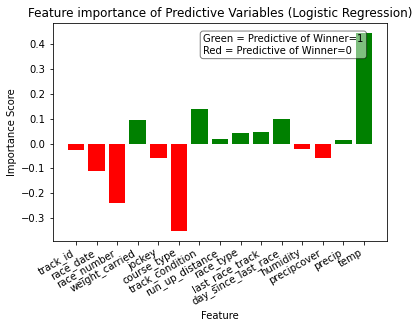

In [61]:
# Plot feature importance
fig, ax = plt.subplots()
plt.bar(imp_df.Feature[:15], imp_df.Importance[:15], color=['r' if v < 0 else 'g' for v in imp_df.Importance])
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title("Feature importance of Predictive Variables (Logistic Regression)")
plt.xlabel("Feature")
plt.ylabel("Importance Score")
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
textstr = '\n'.join(('Green = Predictive of Winner=1', 'Red = Predictive of Winner=0'))
ax.text(0.45, 0.95, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)
plt.show()

### Model # 2 = Decision Tree for Binary Classification of Win vs. Loss

### 1) Train the DT Model

In [24]:
## Initialize and fit model
dt_gini =DecisionTreeClassifier(criterion='gini', ##"entropy" or "gini"
                            splitter='best',  ## or "random" or "best"
                            max_depth=10, 
                            min_samples_split=2, 
                            min_samples_leaf=1, 
                            min_weight_fraction_leaf=0.0, 
                            max_features=100, 
                            random_state=5, 
                            max_leaf_nodes=None, 
                            min_impurity_decrease=0.0, 
                            min_impurity_split=None, 
                            class_weight=None)

dt_gini.fit(X_train_sc, y_train)

DecisionTreeClassifier(max_depth=10, max_features=100, random_state=5)

#### 2) Predict Outcomes

In [25]:
### Predict new labels
#Predict y value for test dataset
y_predict = dt_gini.predict(X_test_sc)
y_prob = dt_gini.predict_proba(X_test_sc)[:,1]

print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))

              precision    recall  f1-score   support

         0.0       0.65      0.97      0.78       910
         1.0       0.81      0.21      0.33       599

    accuracy                           0.67      1509
   macro avg       0.73      0.59      0.55      1509
weighted avg       0.71      0.67      0.60      1509

Confusion Matrix: [[880  30]
 [475 124]]


#### 3) Feature Importance

In [26]:
importance = dt_gini.feature_importances_
imp_list = []

# Summarize feature importance
for i, v in enumerate(importance):
    #print('Feature: %0d, Score: %.5f' % (i,v))
    imp_list.append('Feature: %0d, Score: %.5f' % (i,v))

# Convert imp_list to dataframe
imp_df = pd.DataFrame(imp_list, columns=["Feature"])


### Convert to dataframe for interpretability
imp_df = imp_df["Feature"].str.split(",", expand=True)
imp_df.columns = ["Feature", "Importance"]

imp_df["Importance"] = imp_df["Importance"].str[7:]
imp_df["Importance"] = imp_df["Importance"].astype('float')

# Replace feature numbers with feature names
imp_df["Feature"] = X_train.columns

# Sort by importance
imp_df.sort_values(by=['Importance'])

,Feature,Importance
0,track_id,0.00000
728,rails,0.00000
729,rallied,0.00000
730,rally,0.00000
732,range,0.00000
...,...,...
267,empty,0.06266
1072,weakened,0.07473
688,pr,0.07801
602,no,0.16964


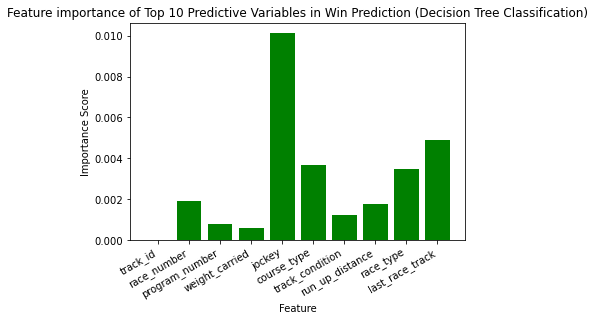

In [27]:
# Plot feature importance
fig, ax = plt.subplots()
plt.bar(imp_df.Feature[:10], imp_df.Importance[:10], color=['r' if v < 0 else 'g' for v in imp_df.Importance])
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title("Feature importance of Top 10 Predictive Variables in Win Prediction (Decision Tree Classification)")
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.show()

### Model # 3 = Random Forest for Binary Classification of Win vs. Loss

#### 1) Model Building --> Train, Hyperparameter Tuning, Predict

In [21]:
## Train the Random Forest alg
accuracies = []
## Hyper parameter tuning --> try between 2-100 trees
for i in range(2,20):
    rf_classifier = RandomForestClassifier(n_estimators=i, random_state=0)
    rf_classifier.fit(X_train_sc, y_train)

    # Predict new labels on testing dataset
    y_predict = rf_classifier.predict(X_test_sc)

    # Get accuracy score and append
    accuracies.append(accuracy_score(y_test, y_predict))

# Find number of trees that maximizes accuracy
max_index = accuracies.index(max(accuracies))
num_trees = max_index-2

# Run model with optimized number of trees
rf_classifier = RandomForestClassifier(n_estimators = num_trees, random_state=0)
rf_classifier.fit(X_train, y_train)
y_predict = rf_classifier.predict(X_test)

# Print classification report
print(classification_report(y_test,y_predict))
print('Confusion Matrix:', confusion_matrix(y_test, y_predict))

              precision    recall  f1-score   support

         0.0       0.77      0.89      0.82       910
         1.0       0.78      0.60      0.67       599

    accuracy                           0.77      1509
   macro avg       0.77      0.74      0.75      1509
weighted avg       0.77      0.77      0.77      1509

Confusion Matrix: [[808 102]
 [242 357]]


#### 2) Feature Importance

In [22]:
importance = rf_classifier.feature_importances_
imp_list = []

# Summarize feature importance
for i, v in enumerate(importance):
    #print('Feature: %0d, Score: %.5f' % (i,v))
    imp_list.append('Feature: %0d, Score: %.5f' % (i,v))

# Convert imp_list to dataframe
imp_df = pd.DataFrame(imp_list, columns=["Feature"])


### Convert to dataframe for interpretability
imp_df = imp_df["Feature"].str.split(",", expand=True)
imp_df.columns = ["Feature", "Importance"]

imp_df["Importance"] = imp_df["Importance"].str[7:]
imp_df["Importance"] = imp_df["Importance"].astype('float')

# Replace feature numbers with feature names
imp_df["Feature"] = X_train.columns

# Sort by importance
imp_df.sort_values(by=['Importance'])

,Feature,Importance
558,met,0.00000
368,gh,0.00000
786,rouse,0.00000
366,gently,0.00000
365,gent,0.00000
...,...,...
10,day_since_last_race,0.02710
15,maxt,0.02735
2,program_number,0.03081
969,tired,0.03655


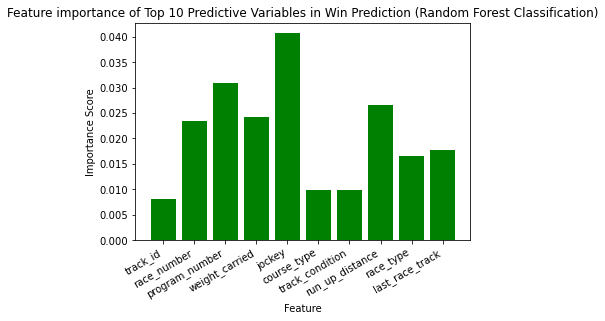

In [23]:
# Plot feature importance
fig, ax = plt.subplots()
plt.bar(imp_df.Feature[:10], imp_df.Importance[:10], color=['r' if v < 0 else 'g' for v in imp_df.Importance])
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title("Feature importance of Top 10 Predictive Variables in Win Prediction (Random Forest Classification)")
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.show()

#### Visualize

Confusion Matrix: [[877  24]
 [426 182]]
False Positive Rate:  0.026637069922308545
True Positive Rate:  0.17186024551463644


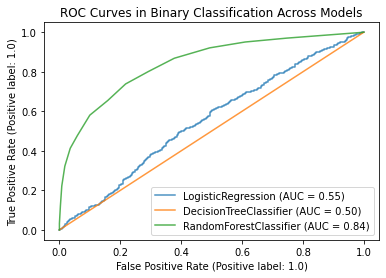

In [43]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, plot_roc_curve

# Calculate FPR and TPR
print('Confusion Matrix:', confusion_matrix(y_test, y_predict))
tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
fpr = (fp/(fp+tn))
tpr = (tp/(tp+tn))
print("False Positive Rate: ", fpr)
print("True Positive Rate: ", tpr)

ax = plt.gca()
plot_roc_curve(lr, X_test, y_test, ax=ax, alpha=0.8)
plot_roc_curve(dt_gini, X_test, y_test, ax=ax, alpha=0.8)
plot_roc_curve(rf_classifier, X_test, y_test, ax=ax, alpha=0.8)
plt.title("ROC Curves in Binary Classification Across Models")
plt.show()